# Guess the age 2022-2023
Group 9:
*   Antonello Avella
*   Eugenio Carpentieri
*   Valerio Costantino
*   Claudio De Pisapia



## Init

In [1]:
%pip install opencv-python scipy tensorflow scikit-learn lightgbm xgboost catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 20.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Metrics and loss




In [3]:
import cv2
import numpy as np

from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten, Dropout

from keras.utils import plot_model
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import keras
#TO USE RandomForest uncomment the following line
#from cuml import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from keras.layers.pooling.global_average_pooling1d import GlobalAveragePooling1D

In [14]:
@tf.function
def AAR_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mae_fun = tf.keras.losses.MeanAbsoluteError()
    mae = mae_fun(y_true, y_pred)
    print(mae)

    condition = tf.less_equal(y_true, 0.1)
    indices = tf.where(condition) 
    mae_1 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_1 = tf.square(mae_1-mae)

    condition1 = tf.less_equal(y_true, 0.2)
    condition2 = tf.greater(y_true, 0.1)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_2 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_2 = tf.square(mae_2-mae)

    condition1 = tf.less_equal(y_true, 0.3)
    condition2 = tf.greater(y_true, 0.2)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_3 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_3 = tf.square(mae_3-mae)

    condition1 = tf.less_equal(y_true, 0.4)
    condition2 = tf.greater(y_true, 0.3)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_4 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_4 = tf.square(mae_4-mae)

    condition1 = tf.less_equal(y_true, 0.5)
    condition2 = tf.greater(y_true, 0.4)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_5 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_5 = tf.square(mae_5-mae)

    condition1 = tf.less_equal(y_true, 0.6)
    condition2 = tf.greater(y_true, 0.5)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_6 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_6 = tf.square(mae_6-mae)

    condition1 = tf.less_equal(y_true, 0.7)
    condition2 = tf.greater(y_true, 0.6)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_7 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_7 = tf.square(mae_7-mae)

    condition = tf.greater(y_true, 0.7)
    indices = tf.where(condition)
    mae_8 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_8 = tf.square(mae_8-mae)

    mae_temp = tf.stack([mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7, mae_8], axis=0)
    print("MAE's of all age groups: ", mae_temp)
    indices = tf.where(tf.logical_not(tf.math.is_nan(mae_temp)))
    mae_total = tf.gather(mae_temp, indices)
    mmae = tf.reduce_mean(mae_total)
    mae_diff_temp = tf.stack([mae_diff_1, mae_diff_2, mae_diff_3, mae_diff_4, mae_diff_5, mae_diff_6, mae_diff_7, mae_diff_8])
    variance_temp = tf.gather(mae_diff_temp, indices)
    variance = tf.sqrt(tf.reduce_mean(variance_temp))
    print(mmae)
    print(variance)
    #𝐴𝐴𝑅 = max(0; 5 − 𝑚𝑀𝐴𝐸) + max(0; 5 − 𝜎)
    AAR = tf.math.maximum(tf.zeros((1,)),tf.constant(5, dtype=tf.float32)-mmae*100)+tf.math.maximum(tf.zeros((1,)),tf.constant(5, dtype=tf.float32)-variance*100)

    return AAR

In [5]:
@tf.function
def AAR_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mae_fun = tf.keras.losses.MeanAbsoluteError()
    mae = mae_fun(y_true, y_pred)
    

    condition = tf.less_equal(y_true, 0.1)
    indices = tf.where(condition)
    mae_1 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_1 = tf.square(mae_1-mae)

    condition1 = tf.less_equal(y_true, 0.2)
    condition2 = tf.greater(y_true, 0.1)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_2 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_2 = tf.square(mae_2-mae)

    condition1 = tf.less_equal(y_true, 0.3)
    condition2 = tf.greater(y_true, 0.2)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_3 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_3 = tf.square(mae_3-mae)

    condition1 = tf.less_equal(y_true, 0.4)
    condition2 = tf.greater(y_true, 0.3)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_4 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_4 = tf.square(mae_4-mae)

    condition1 = tf.less_equal(y_true, 0.5)
    condition2 = tf.greater(y_true, 0.4)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_5 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_5 = tf.square(mae_5-mae)

    condition1 = tf.less_equal(y_true, 0.6)
    condition2 = tf.greater(y_true, 0.5)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_6 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_6 = tf.square(mae_6-mae)

    condition1 = tf.less_equal(y_true, 0.7)
    condition2 = tf.greater(y_true, 0.6)
    condition = tf.logical_and(condition1, condition2)
    indices = tf.where(condition)
    mae_7 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_7 = tf.square(mae_7-mae)

    condition = tf.greater(y_true, 0.7)
    indices = tf.where(condition)
    mae_8 = mae_fun(tf.gather(y_true, indices), tf.gather(y_pred, indices))
    mae_diff_8 = tf.square(mae_8-mae)

    mae_temp = tf.stack([mae_1, mae_2, mae_3, mae_4, mae_5, mae_6, mae_7, mae_8], axis=0)
    indices = tf.where(tf.logical_not(tf.math.is_nan(mae_temp)))
    mae_total = tf.gather(mae_temp, indices)
    mmae = tf.reduce_mean(mae_total)
    mae_diff_temp = tf.stack([mae_diff_1, mae_diff_2, mae_diff_3, mae_diff_4, mae_diff_5, mae_diff_6, mae_diff_7, mae_diff_8])
    variance_temp = tf.gather(mae_diff_temp, indices)
    variance = tf.sqrt(tf.reduce_mean(variance_temp))

    AAR_loss = 0.5*mmae + 0.5*variance

    return AAR_loss

In [12]:
#RUN THIS
tf.config.run_functions_eagerly(True)

## Backbone load

In [8]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/xception09_final', compile=False)
final_model.trainable = False
final_model.summary()

Model: "Final_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,123,881
Trainable params: 0
Non-trainable params: 21,123,881
__________________________________________

## Features load

In [6]:
x_train = np.load('/content/drive/MyDrive/xception_x_train.npy')
y_train = np.load('/content/drive/MyDrive/xception_y_train.npy')

In [7]:
x_val = np.load('/content/drive/MyDrive/xception_x_val.npy')
y_val = np.load('/content/drive/MyDrive/xception_y_val.npy')

## Plotting histograms of training and validation set distributions

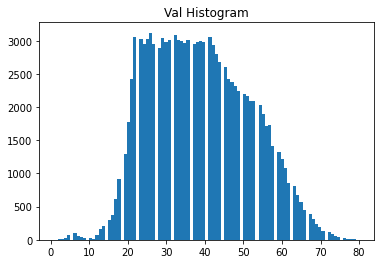

In [ ]:
_ = plt.hist(y_val*100, bins='auto')
plt.title("Val Histogram")
plt.show()

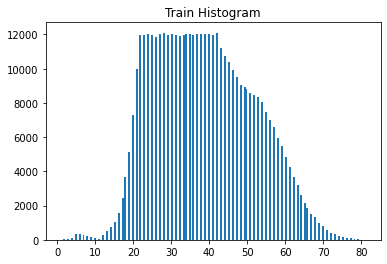

In [ ]:
_ = plt.hist(y_train*100, bins='auto')
plt.title("Train Histogram")
plt.show()

## Test of our base model

In [11]:
model_final = keras.Model(inputs=final_model.layers[3].input, outputs=final_model.layers[4].output)
model_final.trainable = True
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 262,401
Trainable params: 262,401
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_val_pred = model_final.predict(x_val)
y_train_pred = model_final.predict(x_train)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14377/14377 [==============================] - 25s 2ms/step


In [17]:
print(AAR_metric(y_val, y_val_pred))
print(AAR_metric(y_train, y_train_pred))



tf.Tensor(0.01749465, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.00545098 0.01282824 0.01739667 0.01984034 0.01876509 0.01571899
 0.01186001 0.0058276 ], shape=(8,), dtype=float32)
tf.Tensor([7.99723], shape=(1,), dtype=float32)
tf.Tensor(0.017334638, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.0032213  0.01233381 0.01727043 0.01987219 0.01850417 0.01559626
 0.01135642 0.00533285], shape=(8,), dtype=float32)
tf.Tensor([7.986329], shape=(1,), dtype=float32)


## Test of our final model without last dense layers replaced by XGBoost regressor

In [ ]:
xg_reg = XGBRegressor(objective ='reg:squarederror', verbosity=2, n_jobs = 10, learning_rate = 0.1, max_depth = 35, 
                      eval_metric='mae', tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

xg_reg.fit(x_train,y_train)



In [ ]:
y_val_pred = xg_reg.predict(x_val)
y_train_pred = xg_reg.predict(x_train)

In [ ]:
print(AAR_metric(y_val, y_val_pred))
print(AAR_metric(y_train, y_train_pred))

tf.Tensor(0.015682062, shape=(), dtype=float32)
tf.Tensor(0.019262753, shape=(), dtype=float32)
tf.Tensor(0.016103636, shape=(), dtype=float32)
tf.Tensor(0.01887714, shape=(), dtype=float32)
tf.Tensor(0.018676082, shape=(), dtype=float32)
tf.Tensor(0.016328454, shape=(), dtype=float32)
tf.Tensor(0.014996841, shape=(), dtype=float32)
0.008977595
tf.Tensor([8.049485], shape=(1,), dtype=float32)
tf.Tensor(0.00021891166, shape=(), dtype=float32)
tf.Tensor(0.00025325033, shape=(), dtype=float32)
tf.Tensor(0.00021649954, shape=(), dtype=float32)
tf.Tensor(0.00020756247, shape=(), dtype=float32)
tf.Tensor(0.0001875833, shape=(), dtype=float32)
tf.Tensor(0.00019738004, shape=(), dtype=float32)
tf.Tensor(0.00021674715, shape=(), dtype=float32)
0.0002146763
tf.Tensor([9.976643], shape=(1,), dtype=float32)


## Test of our final model without last dense layers replaced by Light GBM regressor

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

In [ ]:
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 40,
    'metric': {'l1'},
    'verbose': -1,
    'n_estimators' : 300,
    'learning_rates' : 'eta',
    'tree_learner' : 'voting',
    'num_boost_round' : 300
}

LGBmodel = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                 early_stopping_rounds=20)

[1]	valid_0's l1: 0.0972531
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.088045
[3]	valid_0's l1: 0.079797
[4]	valid_0's l1: 0.0724194
[5]	valid_0's l1: 0.0658224
[6]	valid_0's l1: 0.0599321
[7]	valid_0's l1: 0.0546803
[8]	valid_0's l1: 0.049991
[9]	valid_0's l1: 0.0458181
[10]	valid_0's l1: 0.0421152
[11]	valid_0's l1: 0.0388277
[12]	valid_0's l1: 0.0359249
[13]	valid_0's l1: 0.0333625
[14]	valid_0's l1: 0.0311066
[15]	valid_0's l1: 0.0291227
[16]	valid_0's l1: 0.0273903
[17]	valid_0's l1: 0.0258818
[18]	valid_0's l1: 0.0245685
[19]	valid_0's l1: 0.023431
[20]	valid_0's l1: 0.0224521
[21]	valid_0's l1: 0.0216097
[22]	valid_0's l1: 0.0208867
[23]	valid_0's l1: 0.0202687
[24]	valid_0's l1: 0.0197424
[25]	valid_0's l1: 0.0192971
[26]	valid_0's l1: 0.0189185
[27]	valid_0's l1: 0.0185979
[28]	valid_0's l1: 0.0183274
[29]	valid_0's l1: 0.0180977
[30]	valid_0's l1: 0.0179028
[31]	valid_0's l1: 0.01774
[32]	valid_0's l1: 0.0176031
[33]	valid_0's l1: 0.0174

In [ ]:
y_val_pred = LGBmodel.predict(x_val)
y_train_pred = LGBmodel.predict(x_train)

In [ ]:
print(AAR_metric(y_val, np.around(y_val_pred, 2)))
print(AAR_metric(y_train, np.around(y_train_pred, 2)))

tf.Tensor(0.013781094, shape=(), dtype=float32)
tf.Tensor(0.01715588, shape=(), dtype=float32)
tf.Tensor(0.014945913, shape=(), dtype=float32)
tf.Tensor(0.017966801, shape=(), dtype=float32)
tf.Tensor(0.018246852, shape=(), dtype=float32)
tf.Tensor(0.015416433, shape=(), dtype=float32)
tf.Tensor(0.013256189, shape=(), dtype=float32)
0.008165327
tf.Tensor([8.164072], shape=(1,), dtype=float32)
tf.Tensor(0.009943959, shape=(), dtype=float32)
tf.Tensor(0.015220477, shape=(), dtype=float32)
tf.Tensor(0.014210201, shape=(), dtype=float32)
tf.Tensor(0.017115692, shape=(), dtype=float32)
tf.Tensor(0.017082805, shape=(), dtype=float32)
tf.Tensor(0.014520914, shape=(), dtype=float32)
tf.Tensor(0.012114633, shape=(), dtype=float32)
0.0077492483
tf.Tensor([8.275942], shape=(1,), dtype=float32)


## Test of our final model without last dense layers replaced by CatBoost regressor

In [ ]:
cat_model = CatBoostRegressor(
    iterations=15000,
    learning_rate=0.0001,
    task_type='GPU',
    loss_function='MAE'
)
  
cat_model.fit(
      x_train, y_train,
      eval_set=(x_val, y_val),
      verbose=10
)     

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.1071542	test: 0.1072402	best: 0.1072402 (0)	total: 131ms	remaining: 32m 45s
10:	learn: 0.1067478	test: 0.1068329	best: 0.1068329 (10)	total: 836ms	remaining: 18m 59s
20:	learn: 0.1063421	test: 0.1064265	best: 0.1064265 (20)	total: 1.48s	remaining: 17m 35s
30:	learn: 0.1059358	test: 0.1060195	best: 0.1060195 (30)	total: 2.11s	remaining: 17m
40:	learn: 0.1055299	test: 0.1056128	best: 0.1056128 (40)	total: 2.75s	remaining: 16m 44s
50:	learn: 0.1051238	test: 0.1052060	best: 0.1052060 (50)	total: 3.4s	remaining: 16m 36s
60:	learn: 0.1047180	test: 0.1047993	best: 0.1047993 (60)	total: 4.04s	remaining: 16m 28s
70:	learn: 0.1043119	test: 0.1043925	best: 0.1043925 (70)	total: 4.67s	remaining: 16m 22s
80:	learn: 0.1039063	test: 0.1039862	best: 0.1039862 (80)	total: 5.31s	remaining: 16m 18s
90:	learn: 0.1035001	test: 0.1035793	best: 0.1035793 (90)	total: 5.95s	remaining: 16m 14s
100:	learn: 0.1030943	test: 0.1031726	best: 0.1031726 (100)	total: 6.58s	remaining: 16m 10s
110:	learn: 0.1

In [ ]:
y_val_pred = cat_model.predict(x_val)
y_train_pred = cat_model.predict(x_train)

In [ ]:
print(AAR_metric(y_val, np.around(y_val_pred, 2)))
print(AAR_metric(y_train, np.around(y_train_pred, 2)))

MAE's of all age groups:  tf.Tensor(
[0.0120398  0.01626687 0.01496185 0.01808313 0.01828506 0.01505594
 0.01252063 0.00731855], shape=(8,), dtype=float32)
tf.Tensor([8.168375], shape=(1,), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.00929639 0.0155615  0.01484375 0.01794397 0.01796895 0.01476417
 0.01171368 0.00656596], shape=(8,), dtype=float32)
tf.Tensor([8.181248], shape=(1,), dtype=float32)


In [ ]:
cat_model.save_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/regressor')

## Finetuning base

In [ ]:
model_final.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001, clipvalue=1.), loss=AAR_loss, metrics=["mae", AAR_metric])

epochs = 100

model_final.fit(
    x_train, y_train,
    workers=25,
    batch_size=32,
    #steps_per_epoch=(n_train_samples) // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #validation_steps=n_val_samples // batch_size,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/' + 'xception_double_finetuning', monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor="val_loss", patience=3)])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_3_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_3_grad/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradients/GatherV2_3_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr

14377/14377 [==============================] - 93s 6ms/step - loss: 0.0114 - mae: 0.0167 - AAR_metric: 7.7226 - val_loss: 0.0090 - val_mae: 0.0168 - val_AAR_metric: 8.1931
Epoch 2/100
14377/14377 [==============================] - 86s 6ms/step - loss: 0.0114 - mae: 0.0166 - AAR_metric: 7.7278 - val_loss: 0.0090 - val_mae: 0.0168 - val_AAR_metric: 8.1947
Epoch 3/100
14377/14377 [==============================] - 86s 6ms/step - loss: 0.0114 - mae: 0.0166 - AAR_metric: 7.7341 - val_loss: 0.0090 - val_mae: 0.0167 - val_AAR_metric: 8.2003
Epoch 4/100
14377/14377 [==============================] - 87s 6ms/step - loss: 0.0113 - mae: 0.0166 - AAR_metric: 7.7411 - val_loss: 0.0090 - val_mae: 0.0167 - val_AAR_metric: 8.2030
Epoch 5/100
14377/14377 [==============================] - 88s 6ms/step - loss: 0.0113 - mae: 0.0165 - AAR_metric: 7.7417 - val_loss: 0.0090 - val_mae: 0.0167 - val_AAR_metric: 8.2031
Epoch 6/100
14377/14377 [==============================] - 87s 6ms/step - loss: 0.0113 - mae

### Evaluate model

In [20]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/xception_double_finetuning', compile=False)
final_model.trainable = True
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 262,401
Trainable params: 262,401
Non-trainable params: 0
_________________________________________________________________


In [29]:
y_val_pred = final_model.predict(x_val)
y_train_pred = final_model.predict(x_train)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14377/14377 [==============================] - 28s 2ms/step


In [30]:
print(AAR_metric(y_val, y_val_pred))
print(AAR_metric(y_train, y_train_pred))

tf.Tensor(0.016637322, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.00677763 0.01421369 0.01567372 0.01848217 0.01840018 0.01523813
 0.01224497 0.00631236], shape=(8,), dtype=float32)
tf.Tensor(0.013417855, shape=(), dtype=float32)
tf.Tensor(0.0054587373, shape=(), dtype=float32)
tf.Tensor([8.112341], shape=(1,), dtype=float32)
tf.Tensor(0.01646004, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.00465861 0.01367717 0.01557727 0.01846188 0.01815128 0.01504813
 0.0116579  0.00630401], shape=(8,), dtype=float32)
tf.Tensor(0.012942031, shape=(), dtype=float32)
tf.Tensor(0.0059462604, shape=(), dtype=float32)
tf.Tensor([8.111171], shape=(1,), dtype=float32)


## Last model 1

In [ ]:
inputs = keras.Input(shape=(2048, 1))
x = Dense(1024, activation="relu")(inputs)
x = GlobalAveragePooling1D()(x)
x = Dense(1, activation="linear")(x)

model = keras.Model(inputs=inputs, outputs=x, name="sample_model")

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.), loss=AAR_loss, metrics=["mae", AAR_metric])

epochs = 100



In [ ]:
model.fit(
    x_train, y_train,
    workers=25,
    batch_size=32,
    #steps_per_epoch=(n_train_samples) // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #validation_steps=n_val_samples // batch_size,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/' + 'final2_anto', monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor="val_loss", patience=3)])

Epoch 1/100
14377/14377 [==============================] - 357s 25ms/step - loss: 0.0263 - mae: 0.0349 - AAR_metric: 4.9284 - val_loss: 0.0179 - val_mae: 0.0333 - val_AAR_metric: 6.5809
Epoch 2/100
14377/14377 [==============================] - 356s 25ms/step - loss: 0.0251 - mae: 0.0334 - AAR_metric: 5.1402 - val_loss: 0.0172 - val_mae: 0.0319 - val_AAR_metric: 6.6699
Epoch 3/100
14377/14377 [==============================] - 357s 25ms/step - loss: 0.0248 - mae: 0.0329 - AAR_metric: 5.2206 - val_loss: 0.0170 - val_mae: 0.0316 - val_AAR_metric: 6.6982
Epoch 4/100
14377/14377 [==============================] - 356s 25ms/step - loss: 0.0244 - mae: 0.0325 - AAR_metric: 5.2786 - val_loss: 0.0170 - val_mae: 0.0317 - val_AAR_metric: 6.6714
Epoch 5/100
14377/14377 [==============================] - 357s 25ms/step - loss: 0.0242 - mae: 0.0324 - AAR_metric: 5.3016 - val_loss: 0.0166 - val_mae: 0.0308 - val_AAR_metric: 6.7870
Epoch 6/100
14377/14377 [==============================] - 357s 25ms/s

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/final2_anto', compile=False)
model.trainable = True
model.summary()

Model: "sample_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2048, 1)]         0         
                                                                 
 dense (Dense)               (None, 2048, 1024)        2048      
                                                                 
 global_average_pooling1d (G  (None, 1024)             0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.), loss=AAR_loss, metrics=["mae", AAR_metric])

epochs = 100

lr_manager = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

model.fit(
    x_train, y_train,
    workers=25,
    batch_size=32,
    #steps_per_epoch=(n_train_samples) // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #validation_steps=n_val_samples // batch_size,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/' + 'final2_anto_second', monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor="val_loss", patience=5), lr_manager])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_3_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_3_grad/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradients/GatherV2_3_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr

14377/14377 [==============================] - 367s 25ms/step - loss: 0.0232 - mae: 0.0307 - AAR_metric: 5.4999 - val_loss: 0.0165 - val_mae: 0.0307 - val_AAR_metric: 6.8049 - lr: 1.0000e-04
Epoch 2/100
14377/14377 [==============================] - 359s 25ms/step - loss: 0.0231 - mae: 0.0307 - AAR_metric: 5.5183 - val_loss: 0.0166 - val_mae: 0.0309 - val_AAR_metric: 6.7548 - lr: 1.0000e-04
Epoch 3/100
14377/14377 [==============================] - 359s 25ms/step - loss: 0.0232 - mae: 0.0306 - AAR_metric: 5.5065 - val_loss: 0.0165 - val_mae: 0.0306 - val_AAR_metric: 6.8106 - lr: 1.0000e-04
Epoch 4/100
14377/14377 [==============================] - 358s 25ms/step - loss: 0.0230 - mae: 0.0305 - AAR_metric: 5.5416 - val_loss: 0.0164 - val_mae: 0.0304 - val_AAR_metric: 6.8171 - lr: 1.0000e-05
Epoch 5/100
14377/14377 [==============================] - 357s 25ms/step - loss: 0.0230 - mae: 0.0304 - AAR_metric: 5.5451 - val_loss: 0.0164 - val_mae: 0.0305 - val_AAR_metric: 6.8077 - lr: 1.0000e-

### Evaluate model 1

In [21]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/final2_anto_second', compile=False)
final_model.trainable = True
final_model.summary()

Model: "sample_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2048, 1)]         0         
                                                                 
 dense (Dense)               (None, 2048, 1024)        2048      
                                                                 
 global_average_pooling1d (G  (None, 1024)             0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


In [22]:
y_val_pred = final_model.predict(x_val)
y_train_pred = final_model.predict(x_train)

14377/14377 [==============================] - 122s 8ms/step


In [23]:
print(AAR_metric(y_val, y_val_pred))
print(AAR_metric(y_train, y_train_pred))

tf.Tensor(0.030430987, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.10126048 0.06557602 0.03343995 0.03237204 0.02296661 0.02218156
 0.02007069 0.0694296 ], shape=(8,), dtype=float32)
tf.Tensor([2.2431898], shape=(1,), dtype=float32)
tf.Tensor(0.03039617, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.10140812 0.06455352 0.0335843  0.03236026 0.02305938 0.02215545
 0.01937902 0.06902578], shape=(8,), dtype=float32)
tf.Tensor([2.2768013], shape=(1,), dtype=float32)


## Last model 2


In [8]:
inputs = keras.Input(shape=(2048, 1))
x = Dense(1024, activation="relu")(inputs)
x = Dropout(.2)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(.2)(x)
x = GlobalAveragePooling1D()(x)
x = Dense(1, activation="linear")(x)

model = keras.Model(inputs=inputs, outputs=x, name="sample_model")

model.summary()

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.), loss=AAR_loss, metrics=["mae", AAR_metric])

epochs = 100

model.fit(
    x_train, y_train,
    workers=25,
    batch_size=32,
    #steps_per_epoch=(n_train_samples) // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #validation_steps=n_val_samples // batch_size,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/' + 'final_anto', monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor="val_loss", patience=3)])

Model: "sample_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048, 1)]         0         
                                                                 
 dense (Dense)               (None, 2048, 1024)        2048      
                                                                 
 dropout (Dropout)           (None, 2048, 1024)        0         
                                                                 
 dense_1 (Dense)             (None, 2048, 128)         131200    
                                                                 
 dropout_1 (Dropout)         (None, 2048, 128)         0         
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                      

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/final_anto', compile=False)
model.trainable = True
model.summary()

Model: "sample_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2048, 1)]         0         
                                                                 
 dense_38 (Dense)            (None, 2048, 1024)        2048      
                                                                 
 dropout_26 (Dropout)        (None, 2048, 1024)        0         
                                                                 
 dense_39 (Dense)            (None, 2048, 128)         131200    
                                                                 
 dropout_27 (Dropout)        (None, 2048, 128)         0         
                                                                 
 global_average_pooling1d_6   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                      

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.), loss=AAR_loss, metrics=["mae", AAR_metric])

epochs = 100

lr_manager = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

model.fit(
    x_train, y_train,
    workers=25,
    batch_size=32,
    #steps_per_epoch=(n_train_samples) // batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #validation_steps=n_val_samples // batch_size,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/' + 'final_anto_second', monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor="val_loss", patience=6), lr_manager])

Epoch 1/100


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_3_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/GatherV2_3_grad/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradients/GatherV2_3_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr

14377/14377 [==============================] - 707s 49ms/step - loss: 0.0238 - mae: 0.0318 - AAR_metric: 5.3902 - val_loss: 0.0162 - val_mae: 0.0302 - val_AAR_metric: 6.8320 - lr: 1.0000e-04
Epoch 2/100
14377/14377 [==============================] - 700s 49ms/step - loss: 0.0236 - mae: 0.0316 - AAR_metric: 5.4117 - val_loss: 0.0162 - val_mae: 0.0300 - val_AAR_metric: 6.8552 - lr: 1.0000e-04
Epoch 3/100
14377/14377 [==============================] - 700s 49ms/step - loss: 0.0235 - mae: 0.0316 - AAR_metric: 5.4205 - val_loss: 0.0163 - val_mae: 0.0304 - val_AAR_metric: 6.8131 - lr: 1.0000e-04
Epoch 4/100
14377/14377 [==============================] - 700s 49ms/step - loss: 0.0235 - mae: 0.0316 - AAR_metric: 5.4392 - val_loss: 0.0161 - val_mae: 0.0299 - val_AAR_metric: 6.8641 - lr: 1.0000e-04
Epoch 5/100
14377/14377 [==============================] - 701s 49ms/step - loss: 0.0235 - mae: 0.0315 - AAR_metric: 5.4306 - val_loss: 0.0161 - val_mae: 0.0299 - val_AAR_metric: 6.8773 - lr: 1.0000e-

### Evaluate model 2

In [9]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalProject_AV/GTA_CAIP_Contest_Code/final_anto_second', compile=False)
final_model.trainable = True
final_model.summary()

Model: "sample_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 2048, 1)]         0         
                                                                 
 dense_38 (Dense)            (None, 2048, 1024)        2048      
                                                                 
 dropout_26 (Dropout)        (None, 2048, 1024)        0         
                                                                 
 dense_39 (Dense)            (None, 2048, 128)         131200    
                                                                 
 dropout_27 (Dropout)        (None, 2048, 128)         0         
                                                                 
 global_average_pooling1d_6   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                      

In [10]:
y_val_pred = final_model.predict(x_val)
y_train_pred = final_model.predict(x_train)

14377/14377 [==============================] - 153s 11ms/step


In [13]:
print(AAR_metric(y_val, y_val_pred))
print(AAR_metric(y_train, y_train_pred))

tf.Tensor(0.029880682, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.09392432 0.06622002 0.03210472 0.0321246  0.02430819 0.02023486
 0.01823771 0.05539346], shape=(8,), dtype=float32)
tf.Tensor([2.9024203], shape=(1,), dtype=float32)
tf.Tensor(0.029834671, shape=(), dtype=float32)
MAE's of all age groups:  tf.Tensor(
[0.09373035 0.0651166  0.03225201 0.03205658 0.0244158  0.02022067
 0.01756665 0.0554096 ], shape=(8,), dtype=float32)
tf.Tensor([2.9420433], shape=(1,), dtype=float32)
